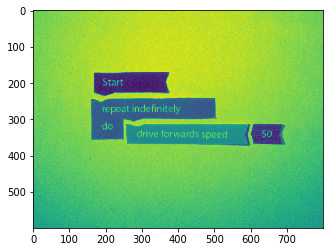

In [84]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 as cv
import pytesseract
import os
from PIL import Image
from scipy.ndimage import label
from scipy.ndimage import binary_closing


A = np.array(Image.open('test_images/new.jpg'))
A = cv.resize(A, dsize=(800, 600), interpolation=cv.INTER_CUBIC)
A_gray = cv.cvtColor(A, cv.COLOR_BGR2GRAY)
plt.imshow(A_gray)
plt.show()

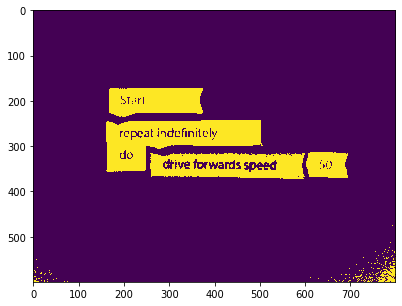

In [85]:
ret, A_bin = cv.threshold(A_gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
A_bin = np.invert(A_bin)
plt.figure(figsize=(15, 5))
plt.imshow(A_bin)
plt.show()

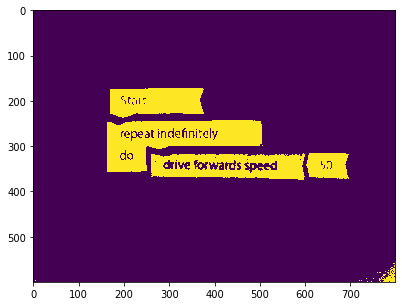

In [86]:
x = 2
kernel = cv.getStructuringElement(cv.MORPH_RECT,(x,x))
opening = cv.morphologyEx(A_bin, cv.MORPH_OPEN, kernel)

plt.figure(figsize=(15,5))
plt.imshow(opening)
plt.show()

Low pixel filter 1440.0 High pixel filter 144000.0
Initial components: 48
Number of selected components: 4


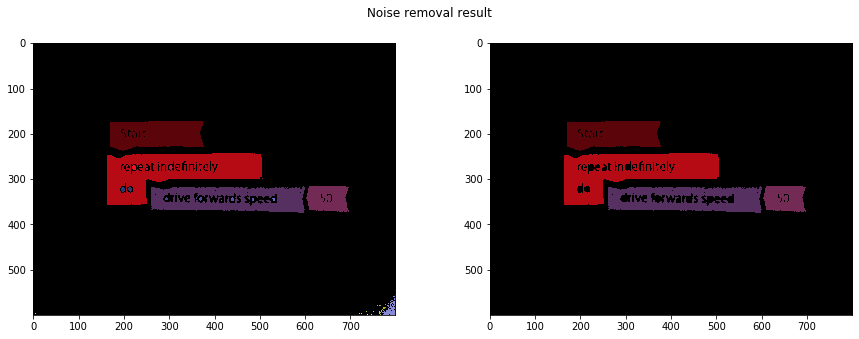

In [87]:
def filter_features(binary):
    features_list = label(binary)
    connected_components = features_list[0]
    processed_result = np.copy(connected_components)
    # remove a feature if it covers over 30% of the image or les than 0.03%
    low_filter = .003*np.prod(connected_components.shape)
    high_filter = .3*np.prod(connected_components.shape)
    print('Low pixel filter {} High pixel filter {}'.format(low_filter, high_filter))
    print('Initial components: {}'.format(features_list[1]))
    components = 0
    for feature in range(features_list[1]):
        if((np.count_nonzero(connected_components == feature) < low_filter) or (np.count_nonzero(connected_components == feature) > high_filter)):
            processed_result[connected_components == feature] = 0
            continue
        components += 1
        #print(np.count_nonzero(css == i))
    print('Number of selected components: {}'.format(components))
    return processed_result, connected_components


res, cc = filter_features(opening)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Noise removal result')
ax1.imshow(cc, cmap='gist_stern')
ax2.imshow(res, cmap='gist_stern')
fig.show()

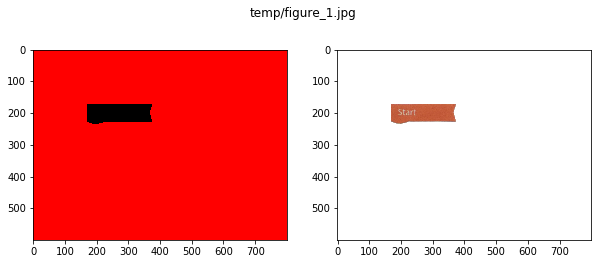

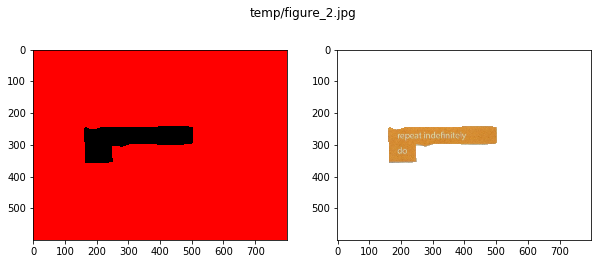

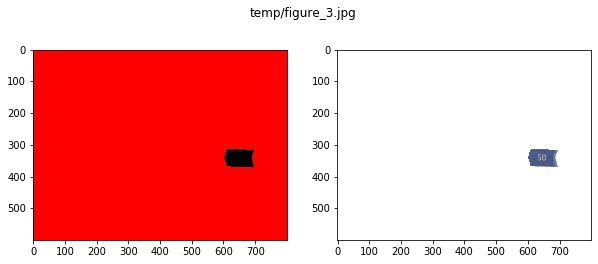

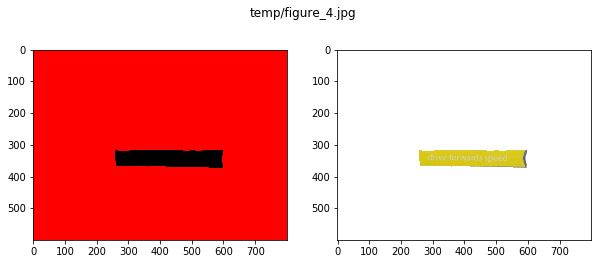

In [88]:
def fill_letters(segmentation, initial_image):
    low_filter = .003*np.prod(segmentation.shape)
    high_filter = .3*np.prod(segmentation.shape)
    window_size = 14 # crusial
    res = np.copy(segmentation)
    number = 0
    for part in range(np.max(segmentation)):
        A = (segmentation == part)
        # closing to each block
        B = binary_closing(A, structure=np.ones((window_size ,  window_size)))
        if(np.count_nonzero(B) < low_filter or np.count_nonzero(B) > high_filter):
            continue
        number += 1
        input_masked = np.copy(initial_image)
        input_masked[B == False] = 255

        filename = 'temp/figure_{}.jpg'.format(number)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        fig.suptitle(filename)
        ax1.imshow(B, cmap='flag')
        ax2.imshow(input_masked, cmap='flag')
        fig.show()   
        figure = Image.fromarray(input_masked)
        figure.save(filename) 
    return(number)

number = fill_letters(res, A)

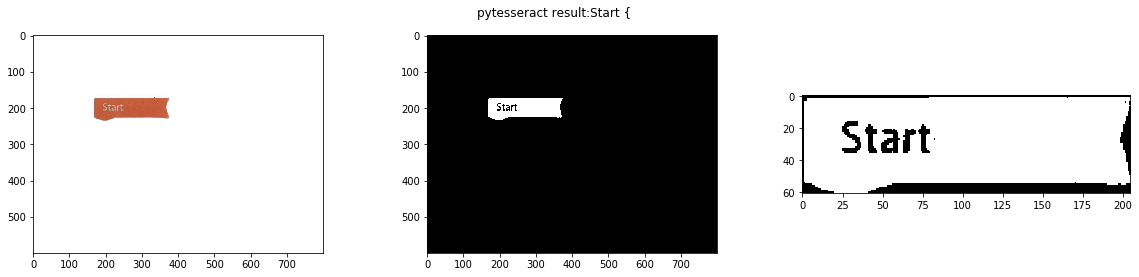

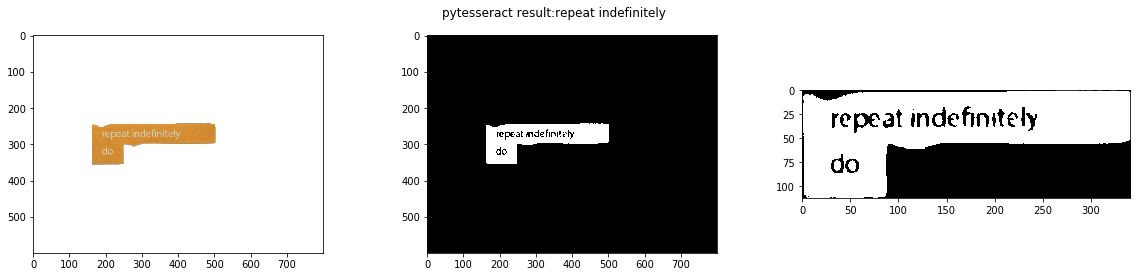

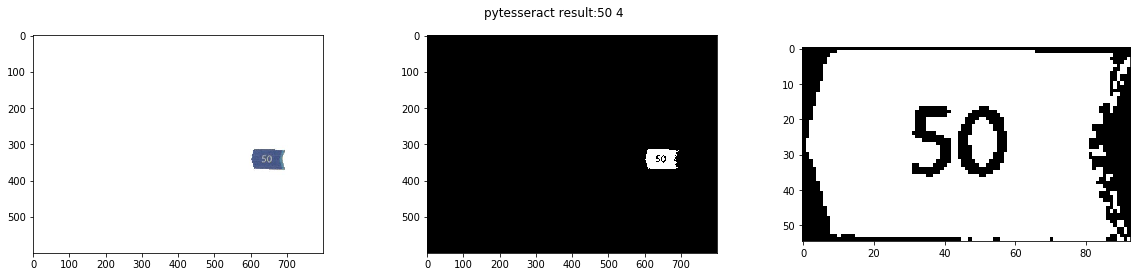

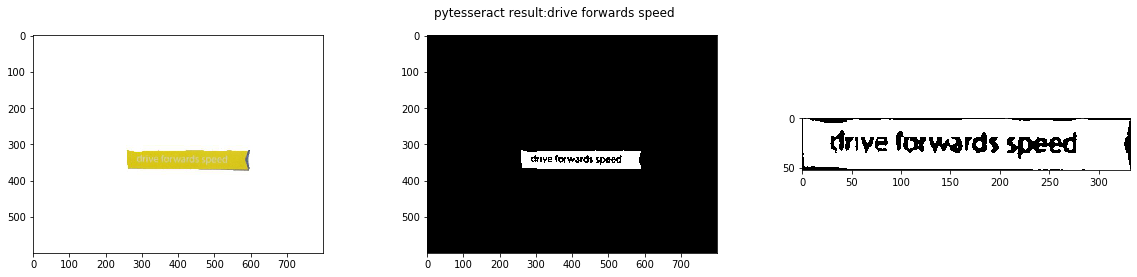

In [89]:
temp_directory = '/home/vasilisp/Desktop/tangibles-recognition/temp/'
pre_guess = 'repeat indefinitely do'

color = {   1 : np.array([195, 72, 97]),  # red
            2 : np.array([213, 143, 54]), # orange
            3 : np.array([67, 85, 133]),  # blue
            4 : np.array([215, 202, 21])   # yellow
        }

color_dict_size = 4 # change this 

#def masking_failed(mask):
#    # if image is all black 
#    # redo 
#    if cv.countNonZero(mask) == 0:
#        return True
#    else:
#        return False

def get_color_thresholds(int):
    c = color[int]
    l_threshold = u_threshold = 50
    lower = np.array([c[0]-l_threshold, c[1]-l_threshold, c[2]-l_threshold]) 
    upper = np.array([c[0]+u_threshold, c[1]+u_threshold, c[2]+u_threshold])
    return upper, lower

#def find_cmask(feature):
#    for i in range(1, color_dict_size+1):
#        upper, lower = get_color_thresholds(i)
#        mask = cv.inRange(figure, lower, upper)
#
#        if not masking_failed(mask):
#            print(i)
#            plt.imshow(mask)
#            plt.show()
#            break
#
#        if i == color_dict_size:
#            print('end of dict')
#            exit(0)
#    return mask
result =  np.copy(A)
for i in range(1, color_dict_size+1):
    figure = np.array(Image.open(temp_directory+'figure_'+str(i)+'.jpg'))
    upper, lower = get_color_thresholds(i)
    mask = cv.inRange(figure, lower, upper)

    canny = cv.Canny(mask, 0, 0)
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    #mask = cv.circle(mask, (x1, y1), 20, (255, 0, 0), 3) 
    y2,x2 = pts.max(axis=0)
    #mask = cv.circle(mask, (x2, y2), 20, (255, 0, 0), 3) 
    cropped = mask[y1:y2, x1:x2]

    result = cv.rectangle(result, (x1, y1), (x2, y2), (36,255,12), 1)
    text_in_block = pytesseract.image_to_string(cropped, lang='eng')
    cv.putText(result, text_in_block, (x1, y1-10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    # planning on making a more sophisticated contains() method
    # for checking tesseracgt output 
    # if pre_guess in text_in_block:
    #    print('tesseract says:'+ pre_guess)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
    fig.suptitle('pytesseract result:'+text_in_block)
    ax1.imshow(figure)
    ax2.imshow(mask, cmap='gray')
    ax3.imshow(cropped, cmap='gray')
    fig.show()  



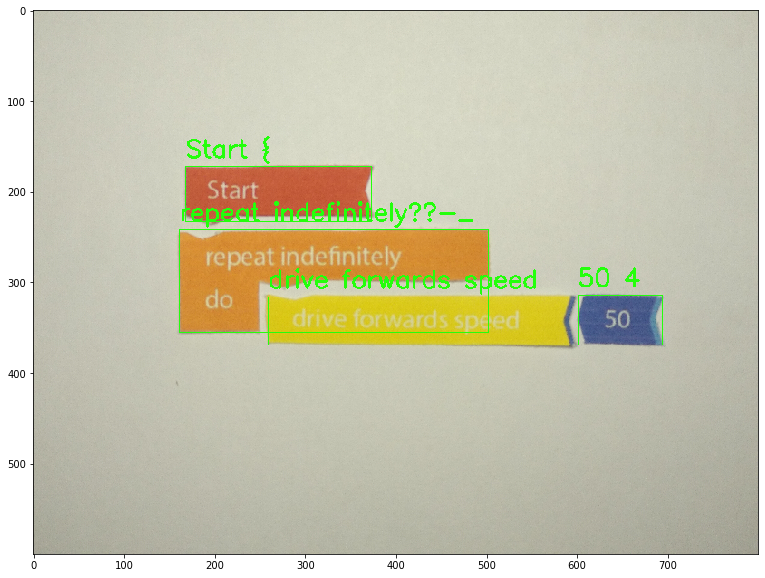

In [90]:
plt.figure(figsize=(15,10))
plt.imshow(result)
plt.show()